In [ ]:
#default_exp data.transform

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.notebook.showdoc import show_doc

In [ ]:
from PIL import Image

# Transforms

## Helpers

In [ ]:
#exports
def type_hints(f):
    "Same as `typing.get_type_hints` but returns `{}` if not allowed type"
    return typing.get_type_hints(f) if isinstance(f, typing._allowed_types) else {}

In [ ]:
#export
def anno_ret(func):
    "Get the return annotation of `func`"
    if not func: return None
    ann = type_hints(func)
    if not ann: return None
    return ann.get('return')

In [ ]:
#hide
def f(x) -> float: return x
test_eq(anno_ret(f), float)
def f(x) -> Tuple[float,float]: return x
test_eq(anno_ret(f), Tuple[float,float])
def f(x) -> None: return x
test_eq(anno_ret(f), NoneType)
def f(x): return x
test_eq(anno_ret(f), None)
test_eq(anno_ret(None), None)

In [ ]:
#export
cmp_instance = functools.cmp_to_key(lambda a,b: 0 if a==b else 1 if issubclass(a,b) else -1)

In [ ]:
td = {int:1, numbers.Number:2, numbers.Integral:3}
test_eq(sorted(td, key=cmp_instance), [numbers.Number, numbers.Integral, int])

In [ ]:
#export
def _p1_anno(f):
    "Get the annotation of first param of `f`"
    hints = type_hints(f)
    ann = [o for n,o in hints.items() if n!='return']
    return ann[0] if ann else object

In [ ]:
def _f(a, b): pass
test_eq(_p1_anno(_f), object)
def _f(a, b)->str: pass
test_eq(_p1_anno(_f), object)
def _f(a, b:str)->float: pass
test_eq(_p1_anno(_f), str)
def _f(a:int, b:int)->float: pass
test_eq(_p1_anno(_f), int)
test_eq(_p1_anno(attrgetter('foo')), object)

## Types

In [ ]:
#export
@delegates(plt.subplots, keep=True)
def subplots(nrows=1, ncols=1, **kwargs):
    fig,ax = plt.subplots(nrows,ncols,**kwargs)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
#export
class TensorImageBase(TensorBase):
    _show_args = {'cmap':'viridis'}
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

    def get_ctxs(self, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
        n_samples = min(self.shape[0], max_n)
        rows = rows or int(np.ceil(math.sqrt(n_samples)))
        cols = cols or int(np.ceil(math.sqrt(n_samples)))
        figsize = (cols*3, rows*3) if figsize is None else figsize
        _,axs = subplots(rows, cols, figsize=figsize)
        return axs.flatten()

In [ ]:
#export
class TensorImage(TensorImageBase): pass

In [ ]:
#export
class TensorImageBW(TensorImage): _show_args = {'cmap':'Greys'}

In [ ]:
#export
class TensorMask(TensorImageBase): _show_args = {'alpha':0.5, 'cmap':'tab20'}

In [ ]:
im = Image.open(TEST_IMAGE)

In [ ]:
im_t = TensorImage(array(im))
test_eq(type(im_t), TensorImage)

In [ ]:
im_t2 = TensorMask(tensor(1))
test_eq(type(im_t2), TensorMask)
test_eq(im_t2, tensor(1))

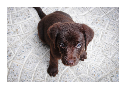

In [ ]:
ax = im_t.show(figsize=(2,2))

In [ ]:
test_fig_exists(ax)

In [ ]:
#hide
axes = im_t.get_ctxs(1)
test_eq(axes.shape,[1])
plt.close()
axes = im_t.get_ctxs(4)
test_eq(axes.shape,[4])
plt.close()

## TypeDispatch -

In [ ]:
#export
class TypeDispatch:
    "Dictionary-like object; `__getitem__` matches keys of types using `issubclass`"
    def __init__(self, *funcs):
        self.funcs,self.cache = {},{}
        for f in funcs: self.add(f)
        self.inst = None

    def _reset(self):
        self.funcs = {k:self.funcs[k] for k in sorted(self.funcs, key=cmp_instance, reverse=True)}
        self.cache = {**self.funcs}

    def add(self, f):
        "Add type `t` and function `f`"
        self.funcs[_p1_anno(f) or object] = f
        self._reset()

    def returns(self, x): return anno_ret(self[type(x)])

    def __repr__(self): return str({getattr(k,'__name__',str(k)):v.__name__ for k,v in self.funcs.items()})

    def __call__(self, x, *args, **kwargs):
        f = self[type(x)]
        if not f: return x
        if self.inst: f = types.MethodType(f, self.inst)
        return f(x, *args, **kwargs)

    def __get__(self, inst, owner):
        self.inst = inst
        return self

    def __getitem__(self, k):
        "Find first matching type that is a super-class of `k`"
        if k in self.cache: return self.cache[k]
        types = [f for f in self.funcs if issubclass(k,f)]
        res = self.funcs[types[0]] if types else None
        self.cache[k] = res
        return res

In [ ]:
def f_col(x:typing.Collection): return x
def f_nin(x:numbers.Integral)->int: return x+1
def f_bti(x:TensorMask): return x
def f_fti(x:TensorImage): return x
def f_bll(x:bool): return x
def f_num(x:numbers.Number): return x
t = TypeDispatch(f_nin,f_fti,f_num,f_bti,f_bll)

test_eq(t[int], f_nin)
test_eq(t[str], None)
test_eq(t[TensorImage], f_fti)
test_eq(t[float], f_num)
t.add(f_col)
test_eq(t[str], f_col)
test_eq(t[int], f_nin)
test_eq(t(1), 2)
test_eq(t.returns(1), int)
t

{'TensorMask': 'f_bti', 'TensorImage': 'f_fti', 'typing.Collection': 'f_col', 'bool': 'f_bll', 'Integral': 'f_nin', 'Number': 'f_num'}

In [ ]:
def m_nin(self, x:numbers.Integral): return x+1
def m_bll(self, x:bool): return x
def m_num(self, x:numbers.Number): return x

t = TypeDispatch(m_nin,m_num,m_bll)
class A: f = t
a = A()
test_eq(a.f(1), 2)
test_eq(a.f(1.), 1.)

## Transform -

In [ ]:
#export
class _TfmDict(dict):
    def __setitem__(self,k,v):
        if k=='_': k='encodes'
        if k not in ('encodes','decodes') or not isinstance(v,Callable): return super().__setitem__(k,v)
        if k not in self: super().__setitem__(k,TypeDispatch())
        res = self[k]
        res.add(v)

In [ ]:
#export
class _TfmMeta(type):
    def __new__(cls, name, bases, dict):
        res = super().__new__(cls, name, bases, dict)
        res.__signature__ = inspect.signature(res.__init__)
        return res

    def __call__(cls, *args, **kwargs):
        f = args[0] if args else None
        n = getattr(f,'__name__',None)
        if not hasattr(cls,'encodes'): cls.encodes=TypeDispatch()
        if not hasattr(cls,'decodes'): cls.decodes=TypeDispatch()
        if isinstance(f,Callable) and n in ('decodes','encodes','_'):
            getattr(cls,'encodes' if n=='_' else n).add(f)
            return f
        return super().__call__(*args, **kwargs)

    @classmethod
    def __prepare__(cls, name, bases): return _TfmDict()

In [ ]:
#export
class Transform(metaclass=_TfmMeta):
    "Delegates (`__call__`,`decode`) to (`encodes`,`decodes`) if `filt` matches"
    filt,init_enc,as_item_force,as_item,order = None,False,None,True,0
    def __init__(self, enc=None, dec=None, filt=None, as_item=True):
        self.filt,self.as_item = ifnone(filt, self.filt),as_item
        self.init_enc = enc or dec
        if not self.init_enc: return

        # Passing enc/dec, so need to remove (base) class level enc/dec
        del(self.__class__.encodes,self.__class__.decodes)
        self.encodes,self.decodes = (TypeDispatch(),TypeDispatch())
        if enc:
            self.encodes.add(enc)
            self.order = getattr(self.encodes,'order',self.order)
        if dec: self.decodes.add(dec)

    @property
    def use_as_item(self): return ifnone(self.as_item_force, self.as_item)
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
    def decode  (self, x, **kwargs): return self._call('decodes', x, **kwargs)
    def __repr__(self): return f'{self.__class__.__name__}: {self.use_as_item} {self.encodes} {self.decodes}'

    def _call(self, fn, x, filt=None, **kwargs):
        if filt!=self.filt and self.filt is not None: return x
        f = getattr(self, fn)
        if self.use_as_item: return self._do_call(f, x, **kwargs)
        res = tuple(self._do_call(f, x_, **kwargs) for x_ in x)
        return retain_type(res, x)

    def _do_call(self, f, x, **kwargs):
        return x if f is None else retain_type(f(x, **kwargs), x, f.returns(x))

add_docs(Transform, decode="Delegate to `decodes` to undo transform")

In [ ]:
show_doc(Transform)

<h2 id="Transform" class="doc_header"><code>class</code> <code>Transform</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/02_data_transforms.ipynb#Transform--" class="source_link" style="float:right">[source]</a></h2>

> <code>Transform</code>(**`enc`**=*`None`*, **`dec`**=*`None`*, **`filt`**=*`None`*, **`as_item`**=*`True`*)

Delegates (`__call__`,`decode`) to ([`encodes`](/vision.core.html#encodes),`decodes`) if `filt` matches

Base class that delegates `__call__` and `decode` to `encodes` and `decodes`, doing nothing if param annotation doesn't match type. If called with listy `x` then it calls function with each item (unless `whole_typle`, in which case it's passed directly as a whole). The function (if matching 1st param type) will cast the result to the same as the input type, unless there's a return annotation (in which case it's cast to that), or the return annotation is `None` (in which case no casting is done).

Details: `Transform` is a base class where you override encodes and/or decodes. e.g. `__call__` uses `call` which looks up what to call using `func`. If `whole_tuple` is set, that just returns `encodes` (or `decodes` if not `is_enc`). Otherwise we find the first annotated param with `_p1_anno` and check if `x` is an instance of that (if not `is_listy(x)`). If it is, we return the function (encodes/decodes), otherwise None. `call` then passes on to `_do_call` which does nothing if function is `None`. If `x` is listy, then we return a *list* of {functions or `None`}, and a list of results from `_do_call` for each function is returned.

In [ ]:
class A(Transform): pass
@A
def encodes(self, x): return x+1
f1 = A()
test_eq(f1(1), 2)

class B(A): pass
f2 = B()
test_eq(f2(1), 2)

class A(Transform): pass
f3 = A()
test_eq_type(f3(2), 2)
test_eq_type(f3.decode(2.0), 2.0)

Return annotation is used to ensure we get an `Int`. Since `decodes` doesn't exist, `decode` does nothing.

In [ ]:
@Transform
def f(x)->Int: return x/2
test_eq_type(f(2), Int(1))
test_eq_type(f.decode(2.0), 2.0)
f

Transform: True {'object': 'f'} {}

In [ ]:
class A(Transform):
    def _(self, x:TensorImage): return -x
f = A()
t = f(im_t)
test_eq(t, -im_t)
test_eq(f(1), 1)
test_eq(type(t), TensorImage)
f

A: True {'TensorImage': '_'} {}

Without return annotation we get an `Int` back since that's what was passed.

In [ ]:
class A(Transform): pass
@A
def _(self, x:Int): return x//2  # `_` is an abbreviation for `encodes`
@A
def encodes(self, x:float): return x+1

f = A()
test_eq_type(f(Int(2)), Int(1))
test_eq_type(f(2), 2)
test_eq_type(f(2.), 3.)

Without return annotation we don't cast if we're not a subclass of the input type.

In [ ]:
class A(Transform):
    def encodes(self, x:Int): return x/2
    def _(self, x:float): return x+1

f = A()
test_eq_type(f(Int(2)), 1.)
test_eq_type(f(2), 2)
test_eq_type(f(Float(2.)), Float(3.))

With return annotation `None` we get back whatever Python creates usually.

In [ ]:
def func(x)->None: return x/2
f = Transform(func)
test_eq_type(f(2), 1.)
test_eq_type(f(2.), 1.)

Since `decodes` has no return annotation, but `encodes` created an `Int` and we pass that result here to `decode`, we end up with an `Int`.

In [ ]:
def func(x)->Int: return x+1
def dec (x): return x-1
f = Transform(func,dec)
t = f(1)
test_eq_type(t, Int(2))
test_eq_type(f.decode(t), Int(1))

If the transform has `filt` then it's only applied if `filt` param matches.

In [ ]:
f.filt = 1
test_eq(f(1, filt=1),2)
test_eq_type(f(1, filt=0), 1)

In [ ]:
class A(Transform): 
    def encodes(self, xy): x,y=xy; return (x+y,y)
    def decodes(self, xy): x,y=xy; return (x-y,y)

f = A()
t = f((1,2))
test_eq(t, (3,2))
test_eq(f.decode(t), (1,2))
f.filt = 1
test_eq(f((1,2), filt=1), (3,2))
test_eq(f((1,2), filt=0), (1,2))

In [ ]:
class AL(Transform): pass
@AL
def encodes(self, x): return L(x_+1 for x_ in x)
@AL
def decodes(self, x): return L(x_-1 for x_ in x)

f = AL()
t = f([1,2])
test_eq(t, [2,3])
test_eq(f.decode(t), [1,2])

In [ ]:
#export
class InplaceTransform(Transform):
    "A `Transform` that modifies in-place and just returns whatever it's passed"
    def __call__(self, x, **kwargs):
        super().__call__(x,**kwargs)
        return x

## TupleTransform

In [ ]:
def neg_int(x:numbers.Integral): return -x

f = Transform(neg_int, as_item=False)
test_eq(f([1]), (-1,))
test_eq(f([1.]), (1.,))
test_eq(f([1.,2,3.]), (1.,-2,3.))
test_eq(f.decode([1,2]), (1,2))

In [ ]:
#export
class TupleTransform(Transform):
    "`Transform` that always treats `as_item` as `False`"
    as_item_force=False

In [ ]:
#export
class ItemTransform (Transform):
    "`Transform` that always treats `as_item` as `True`"
    as_item_force=True

In [ ]:
def float_to_int(x:(float,int))->Int: return x

f = TupleTransform(float_to_int)
test_eq_type(f([1.]), (Int(1),))
test_eq_type(f([1]), (Int(1),))
test_eq_type(f(['1']), ('1',))
test_eq_type(f([1,'1']), (Int(1),'1'))
test_eq(f.decode([1]), [1])

test_eq_type(f(TupleBase((1.,))), TupleBase((Int(1),)))

In [ ]:
class B(TupleTransform): pass
class C(TupleTransform): pass
f = B()
test_eq(f([1]), [1])

In [ ]:
@B
def _(self, x:int): return x+1
@B
def _(self, x:str): return x+'1'
@B
def _(self, x)->None: return str(x)+'!'

b,c = B(),C()
test_eq(b([1]), [2])
test_eq(b(['1']), ('11',))
test_eq(b([1.0]), ('1.0!',))
test_eq(c([1]), [1])
test_eq(b([1,2]), (2,3))
test_eq(b.decode([2]), [2])
assert pickle.loads(pickle.dumps(b))

In [ ]:
@B
def decodes(self, x:int): return x-1
test_eq(b.decode([2]), [1])
test_eq(b.decode(('2',)), ('2',))

Non-type-constrained functions are applied to all elements of a tuple.

In [ ]:
class A(TupleTransform): pass
@A
def _(self, x): return x+1
@A
def decodes(self, x): return x-1

f = A()
t = f((1,2.0))
test_eq_type(t, (2,3.0))
test_eq_type(f.decode(t), (1,2.0))

Type-constrained functions are applied to only matching elements of a tuple, and return annotations are only applied where matching.

In [ ]:
class B(TupleTransform):
    def encodes(self, x:int)->Int: return x+1
    def encodes(self, x:str): return x+'1'
    def decodes(self, x:Int): return x//2

f = B()
start = (1.,2,'3')
t = f(start)
test_eq_type(t, (1.,Int(3),'31'))
test_eq(f.decode(t), (1.,Int(1),'31'))

The same behavior also works with `typing` module type classes.

In [ ]:
class A(Transform): pass
@A
def _(self, x:numbers.Integral): return x+1
@A
def _(self, x:float): return x*3
@A
def decodes(self, x:int): return x-1

f = A()
start = 1.0
t = f(start)
test_eq(t, 3.)
test_eq(f.decode(t), 3)

f = A(as_item=False)
start = (1.,2,3.)
t = f(start)
test_eq(t, (3.,3,9.))
test_eq(f.decode(t), (3.,2,9.))

Transform accepts lists

In [ ]:
def a(x): return L(x_+1 for x_ in x)
def b(x): return L(x_-1 for x_ in x)
f = TupleTransform(a,b)

t = f((L(1,2),))
test_eq(t, (L(2,3),))
test_eq(f.decode(t), (L(1,2),))

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_script.ipynb.
Converted 01a_torch_core.ipynb.
Converted 01c_dataloader.ipynb.
Converted 02_data_transforms.ipynb.
Converted 03_data_pipeline.ipynb.
Converted 04_data_external.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_source.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 11_layers.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 30_text_core.ipynb.
Converted 31_text_data.ipynb.
Converted 32_text_models_awdlstm.ipynb.
Converted 33_test_models_core.ipynb.
Converted 34_callback_rnn.ipynb.
Converted 35_tutorial_wikitext.ipynb.
Converted 36_t